# End to end pipeline

- Run the yolo model on the full size image
- Extract a 64x64 image around the predicted bounding box
- Predict the mask on the cropped image
- Add it to the full size mask (pay attention to the correct slice from the bounding box) 
- Compute the DICE score for the prediction

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 2.0 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 63.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 64.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 65.6 MB/s eta 0:00:01
     |████████████████████████████████| 203 kB 75.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 60.8 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 72.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 75.7 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 15.8 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 74.6 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 9.7 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 6.1 MB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 7.1 MB/s  eta 0:00:01
     |████████████████████████████████| 95 kB 7.2 MB/s  eta 0:00:01
     |████████████████████████████████|

In [2]:
!pip install --upgrade google-auth-oauthlib
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'

     |████████████████████████████████| 25.6 MB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 171 kB 79.0 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 56.1 MB/s eta 0:00:01
     |████████████████████████████████| 514 kB 93.3 MB/s eta 0:00:01


In [73]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [74]:
import matplotlib.patches as patches

"""
    Detect a bounding box around a mask in an image
    Returns an array of bounding boxes
    Bounding box format (origin_x, origin_y, width, height)
"""
def get_bounding_box(img):
    minx = []
    miny = []
    maxx = []
    maxy = []
    contours = find_contours(img.astype(float), 0.5)
    for contour in contours:
        minx.append(np.min(contour[:,1]))
        maxx.append(np.max(contour[:,1]))
        miny.append(np.min(contour[:,0]))
        maxy.append(np.max(contour[:,0]))
        
    if len(minx) > 0:
        return [(a, b, w-a, h-b) for a, b, w, h in zip(minx, miny, maxx, maxy)]
    else:
        return None
    
def plot_bounding_box(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    boxes = get_bounding_box(img)
    if boxes:
        for box in boxes:
            x,y,w,h = box
            print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

"""
    Plot a rectangle on a given image
"""
def plot_box(img, box=None, size=(6,8),):
    fig, ax = plt.subplots(figsize=size)
    ax.imshow(img, cmap=plt.cm.gray)
    if box:
        x,y,w,h = box
        print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

x = 17.5, y = 23.5, w = 23.0, h= 17.0


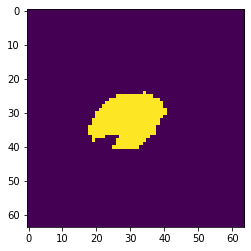

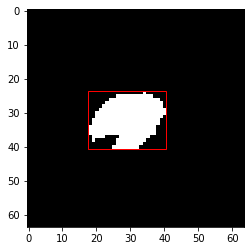

In [75]:
# test the bounding box detection code
# load a mask from the training dataset
train_mask_folder = '/data/unet/train/masks/'
mask = Image.open(train_mask_folder + 'mask_LIDC-IDRI-0001_0_86.jpg')
mask = mask.convert('1')
mask = np.array(mask)
mask = mask.astype(np.uint8)
plt.imshow(mask)
np.unique(mask)
get_bounding_box(mask)
plot_bounding_box(mask)

In [76]:
import math
def convert_yolo_to_bounding_box(tup):
    x, y, w, h = tup
    return (int(x - (w/2)), int(y-(h/2)), w, h)

['0 0.6171875 0.71484375 0.044921875 0.033203125\n']
x = 304, y = 357, w = 23, h= 17


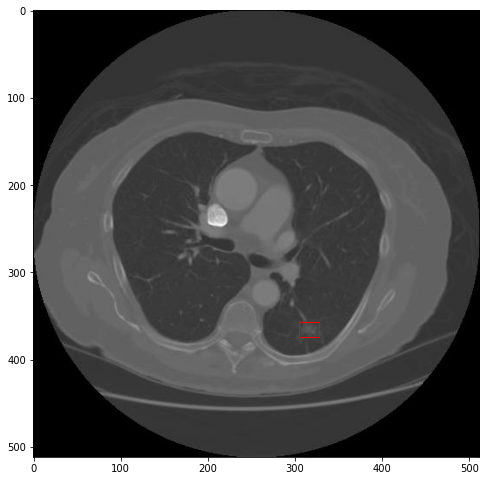

In [77]:
fullsize_image_folder = '/data/yolov5/train/images/'
fullsize_mask_folder = '/data/yolov5/train/labels/'
imgname = 'LIDC-IDRI-0001_86.jpg'
img = Image.open(fullsize_image_folder + imgname)
with open(fullsize_mask_folder + imgname.replace('jpg','txt'), mode='r', encoding="utf-8") as f:
    lines = f.readlines()
    print(lines)
c, x, y, w, h = tuple([int(float(l)*512) for l in lines[0].split()])
plot_box(img, convert_yolo_to_bounding_box((x, y, w, h)), (8, 10))

x = 304, y = 357, w = 23, h= 17


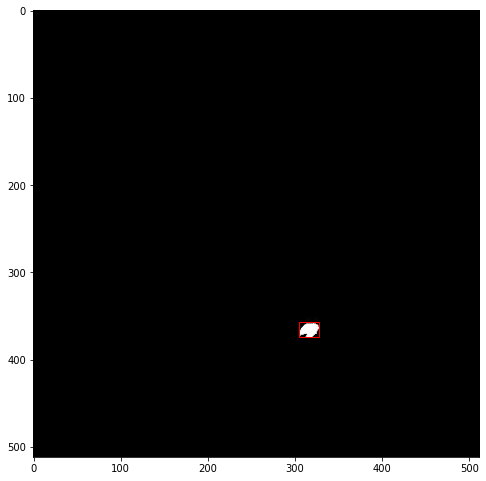

In [78]:
fullsize_image_folder = '/data/unet/fullsize/train/images/'
fullsize_label_folder = '/data/unet/fullsize/train/labels/'
fullsize_mask_folder = '/data/unet/fullsize/train/masks/'
imgname = 'LIDC-IDRI-0001_86.jpg'
img = Image.open(fullsize_image_folder + imgname)
mask = Image.open(fullsize_mask_folder + imgname.replace('img','mask'))
with open(fullsize_label_folder + imgname.replace('jpg','txt'), mode='r', encoding="utf-8") as f:
    lines = f.readlines()
c, x, y, w, h = tuple([int(float(l)*512) for l in lines[0].split()])
plot_box(mask, convert_yolo_to_bounding_box((x, y, w, h)), (8, 10))

In [9]:
## predict the bounding box on this image using Yolo
%cd /app/yolov5
!pip install -r requirements.txt

/app/yolov5
     |████████████████████████████████| 60.3 MB 198 kB/s  eta 0:00:01
     |████████████████████████████████| 292 kB 75.4 MB/s eta 0:00:01


In [11]:
model_weights = '/app/yolov5/runs/train/yolov5s_results3/weights/best.pt'
!python detect.py --weights {model_weights} --img 512 --conf 0.25 --source {fullsize_image_folder + imgname} --save-txt --nosave

detect: weights=['/app/yolov5/runs/train/yolov5s_results3/weights/best.pt'], source=/data/unet/fullsize/train/images/LIDC-IDRI-0001_86.jpg, imgsz=[512, 512], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=True, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-43-g19c8760 torch 1.10.0a0+3fd9dcf CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPs
image 1/1 /data/unet/fullsize/train/images/LIDC-IDRI-0001_86.jpg: 512x512 1 nodule, Done. (0.013s)
Speed: 16.0ms pre-process, 13.0ms inference, 157.0ms NMS per image at shape (1, 3, 512, 512)
Results saved to runs/detect/exp21
1 labels saved to runs/detect/exp21/labels


In [79]:
def yolo_bbox_to_slice(tup):
    x, y, w, h = tup
    #x = 305, y = 358, w = 24, h= 16
    #note, y and x are flipped
    clip = (slice(y, y+h), slice(x, x+w))
    return clip

In [80]:
def get_predicted_box(outdir):
    out_folder_name = "/app/yolov5/runs/detect/{}/labels/".format(outdir)
    files = os.listdir(out_folder_name)
    with open(out_folder_name + imgname.replace('jpg','txt'), mode='r', encoding="utf-8") as f:
        lines = f.readlines()
    c, x, y, w, h = tuple([int(float(l)*512) for l in lines[0].split()])
    clip = convert_yolo_to_bounding_box((x, y, w, h))
    return clip, files

clip= (305, 358, 24, 16)
x = 305, y = 358, w = 24, h= 16


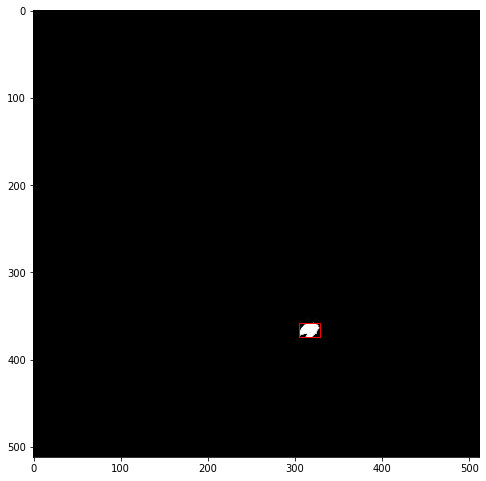

In [81]:
# clip, files = get_predicted_box('exp20')
# print("Predicting for {}".format(files))
outdir = 'exp21'
out_folder_name = "/app/yolov5/runs/detect/{}/labels/".format(outdir)
fullsize_mask_folder = '/data/unet/fullsize/train/masks/'
mask = Image.open(fullsize_mask_folder + imgname.replace('img','mask'))
with open(out_folder_name + imgname.replace('jpg','txt'), mode='r', encoding="utf-8") as f:
    lines = f.readlines()
c, x, y, w, h = tuple([int(float(l)*512) for l in lines[0].split()])
clip = convert_yolo_to_bounding_box((x, y, w, h))
print("clip=", clip)
plot_box(mask, clip, (8, 10))

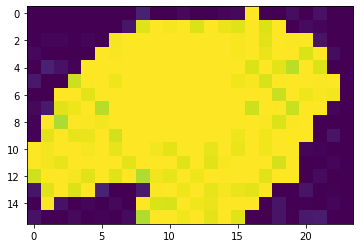

In [12]:
clip_nodule = yolo_bbox_to_slice(clip)
plt.imshow(np.array(mask)[clip_nodule])

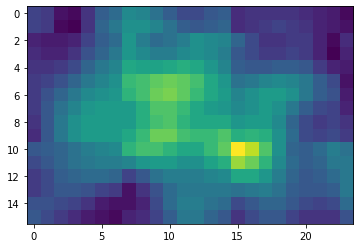

In [14]:
clip_nodule = yolo_bbox_to_slice(clip)
plt.imshow(np.array(img)[clip_nodule])

In [82]:
# get a 64x64 image around the bounding box
# take 32 pixels including c_x on each axis
def get_stride(c):
    start = 0
    if (c - 32) > 0:
        start = c - 32
    else:
        start = 0
    if (c + 32) < 512:
        stop = c + 32
    else:
        stop = 512
    return slice(start, stop, None)

"""
    Get a 64x64 image around the nodule, when using random = false, we get the actual clip of the annotated nodule,
    when using random = true, get a 64x64 image around the nodule randomly chosen which may or may not show a part of the nodule
"""
def get_nodule_part(clip, random=False):
    # extract 64x64 size images from the image randomly including the mask
    c_x = int(clip[0].start + (clip[0].stop - clip[0].start)/2)
    c_y = int(clip[1].start + (clip[1].stop - clip[1].start)/2)
    #print(c_x, c_y)
    if random: # random center within 64x64 box
        c_x = np.random.choice(np.arange(clip[0].start, clip[0].stop))
        c_y = np.random.choice(np.arange(clip[1].start, clip[1].stop))
    return get_stride(c_x), get_stride(c_y)

clip =  (slice(358, 374, None), slice(305, 329, None))


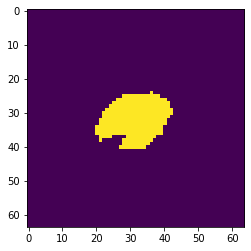

In [83]:
#x = 305, y = 358, w = 24, h= 16
#convert the rect coords to slice
fullsize_mask_folder = '/data/unet/fullsize/train/masks/'
mask = Image.open(fullsize_mask_folder + imgname.replace('img','mask'))
mask = mask.convert('1')
mask = np.array(mask)
mask = mask.astype(np.uint8)
#note, y and x are flipped
clip, files = get_predicted_box('exp21')
clip = yolo_bbox_to_slice(clip)
print("clip = ", clip)
plt.imshow(mask[clip])
cropped_clip = get_nodule_part(clip, random=False)
plt.imshow(mask[cropped_clip])

clip =  (slice(358, 374, None), slice(305, 329, None))


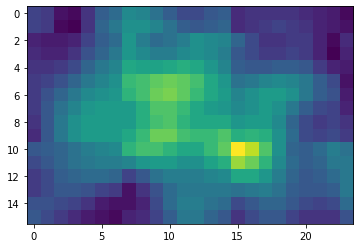

In [84]:
#x = 305, y = 358, w = 24, h= 16
#convert the rect coords to slice
fullsize_mask_folder = '/data/unet/fullsize/train/images/'
image = Image.open(fullsize_mask_folder + imgname)
#mask = mask.convert('1')
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)

#note, y and x are flipped
clip, files = get_predicted_box('exp21')
clip = yolo_bbox_to_slice(clip)
print("clip = ", clip)
plt.imshow(image[clip])
cropped_clip = get_nodule_part(clip, random=False)
#plt.imshow(image[cropped_clip])

247 unique pixels in the full ((512, 512)) image from full size JPG files
89 unique pixels in the cropped ((64, 64)) image from full size JPG files


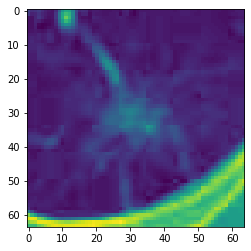

In [85]:
# get the cropped image from yolo prediction
fullsize_image_folder = '/data/unet/fullsize/train/images/'
image = Image.open(fullsize_image_folder + imgname)
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)
#note, y and x are flipped
clip = yolo_bbox_to_slice(convert_yolo_to_bounding_box((x, y, w, h)))
#plt.imshow(img[clip])
cropped_clip = get_nodule_part(clip, random=False)
plt.imshow(image[cropped_clip])
print("{} unique pixels in the full ({}) image from full size JPG files".format(len(np.unique(image)),image.shape))
print("{} unique pixels in the cropped ({}) image from full size JPG files".format(len(np.unique(image[cropped_clip])),image[cropped_clip].shape))

#### Load the cropped images from UNET training data

folder: /data/unet/train/images

In [86]:
unet_train_folder = '/data/unet/train/'

In [87]:
image = Image.open(unet_train_folder + 'images/' + 'img_LIDC-IDRI-0001_0_86.jpg')
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)
print("{} unique pixels in the ({}) image from UNET training JPG files".format(len(np.unique(image)),image.shape))

241 unique pixels in the ((64, 64)) image from UNET training JPG files


Clearly, there is an issue when loading a full size image and cropping it, imageio when saving a cropped image modifies the pixel values so that even a cropped 64x64 image will be saved with 241 unique pixel values.

Let's try to use imageio to convert the cropped image into a rich one in memory.

In [88]:
from io import BytesIO
import imageio
def convert_to_imageio_rich(cropped_img_array):
    buf = BytesIO()
    imageio.imwrite(buf, cropped_img_array, format='jpg')
    buf.seek(0)
    new_arr = Image.open(buf)
    new_arr = np.array(new_arr).astype('float32')
    new_arr -= np.mean(new_arr)
    new_arr /= np.std(new_arr)
    return new_arr

In [89]:
#load the full size JPG file and crop it
fullsize_image_folder = '/data/unet/fullsize/train/images/'
image = Image.open(fullsize_image_folder + imgname)
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)
#note, y and x are flipped
clip = yolo_bbox_to_slice(convert_yolo_to_bounding_box((x, y, w, h)))
cropped_clip = get_nodule_part(clip, random=False)

conv_img_arr = convert_to_imageio_rich(image[cropped_clip])
print("{} unique pixels in the cropped ({}) image from full size JPG files".format(len(np.unique(conv_img_arr)),conv_img_arr.shape))

Lossy conversion from float32 to uint8. Range [-0.17634423077106476, 2.1623523235321045]. Convert image to uint8 prior to saving to suppress this warning.


239 unique pixels in the cropped ((64, 64)) image from full size JPG files


There is still 2 unique pixel values missing. Let's see if this changes when we go back to the source DICOM files to crop the image.

In [90]:

def un(a, b):
    return np.union1d(a, b)

def unr(ll, acc, i):
    if i < len(ll):
        j = i + 1
        acc = un(ll[i], acc)
        return unr(ll, acc, j)
    else:
        return acc

def get_slices_with_masks(cbbox_CT):
    ll = []
    for cb in cbbox_CT:
        ll.append(np.arange(cb[2].start, cb[2].stop+1))
    return unr(ll, [], 0)

"""
    dicom_dir: path to the DICOM images
    returns: the vol, mask, annotated bounding box and the slice indices which have annotated masks
"""
def load_patient_vol_and_mask(dicom_dir, patient_id=-1):
    
    f = open ('/root/.pylidcrc','w')    #For Colab
    f.write('[dicom]'+'\n')
    f.write('path =' + dicom_dir +'\n')
    f.write('warn = True')
    f.close()

    patient_list = os.listdir(dicom_dir)
    if patient_id == -1: #select one randomly
        patient_id = np.random.choice(patient_list)
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    try:
        vol = scan.to_volume()
    except:
        print("Error loading DICOM for patient {}".format(patient_id))
        return None, None, None
    # are there nodules that are useful?

    # process the mask for the image
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        if len(nodule) >= 4:
            cmask, cbbox, masks = consensus(nodule)
            cmask_CT.append(cmask)
            cbbox_CT.append(cbbox)
            masks_CT.append(masks)

    if len(cbbox_CT) <=0:
        print("No relevant nodules for patient {}".format(patient_id))
        return None, None, None


    # create the mask voxel
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    #print("Number of nodules {}".format(nodule_num))
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask

    # get the slices that have annotations
    slices_with_mask = get_slices_with_masks(cbbox_CT)
    
    return vol, CT_mask, cbbox_CT, slices_with_mask

In [91]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/rawdata/train/sorted_gcsfiles', 'LIDC-IDRI-0001')

Loading dicom files ... This may take a moment.


Lossy conversion from float32 to uint8. Range [-0.8964322209358215, 3.6785922050476074]. Convert image to uint8 prior to saving to suppress this warning.


(slice(334, 398, None), slice(285, 349, None))
241 unique pixels in the cropped ((64, 64)) image from raw DICOM image


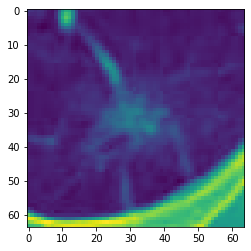

In [92]:
# get the predicted bounding box from the last output folder
clip, files = get_predicted_box('exp21')
# convert yolo bonding box to slice
clip = yolo_bbox_to_slice(clip)
# extract a 64x64 clip with the bounding box at the center
cropped_clip = get_nodule_part(clip, random=False)
print(cropped_clip)
# extract a 64x64 image for the specific slice (depending on which one we predicted on) from the image
image = vol[cropped_clip][:,:,86]
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)
# use imageio to normalize the values
image = convert_to_imageio_rich(image)
plt.imshow(image)
print("{} unique pixels in the cropped ({}) image from raw DICOM image".format(len(np.unique(image)),image.shape))

We will need to load the images from the source (DICOM), predict the bounding box using Yolo and then predict the mask using UNET

In [111]:
test_images_list = os.listdir('/data/yolov5/test/images/')
print("There are {} test images".format(len(test_images_list)))
tup = [(name.split('_')[0],name.split('_')[1].split('.')[0]) for name in test_images_list]
patient_slice = {}
for t in sorted(tup):
    if t[0] in patient_slice:
        patient_slice[t[0]].append(int(t[1]))
    else:
        patient_slice[t[0]] = [int(t[1])]

There are 738 test images


In [117]:
print("There are {} patients in the test dataset.".format(len(patient_slice.keys())))

There are 27 patients in the test dataset.


In [125]:
pid_cnt = [(k, len(patient_slice[k])) for k in patient_slice.keys()]

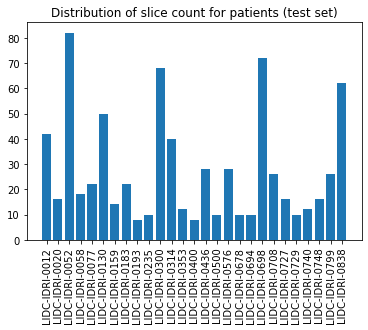

In [145]:
xs = []
ys = []
for x, y in pid_cnt:
    xs.append(x)
    ys.append(y)
f,a = plt.subplots()
a.bar(xs, ys)
plt.xticks(rotation=90)
plt.title('Distribution of slice count for patients (test set)')
plt.show()

#### Predict nodule objects using Yolo

In [159]:
for k in patient_slice.keys():
    print(k)
    print(patient_slice[k])
    break

LIDC-IDRI-0012
[100, 104, 108, 109, 116, 119, 124, 125, 13, 2, 28, 30, 4, 45, 52, 53, 54, 55, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 8, 80, 81, 88, 93, 95, 99]


In [167]:
for k in patient_slice.keys():
    detect_nodules(k, patient_slice[k], dicomdir='/data/yolov5/test/sorted_gcsfiles/', 
                   model_weights = '/app/yolov5/runs/train/yolov5s_results18/weights/best.pt',
                      testdir='/data/yolov5/predict/')
    break

Loading dicom files ... This may take a moment.


Lossy conversion from float64 to uint8. Range [-1.6024935377505356, 4.777343630058491]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.597956523322161, 4.097893197897188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.595126707326903, 4.591565556378221]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.5912138363190926, 4.942378311474704]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.584270794943256, 4.817040198582206]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.5683964828230257, 4.688787576506891]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.5837429326316987, 4.841555106328284

Reading data from /data/yolov5/predict//LIDC-IDRI-0012/images/
Running command:

python detect.py --weights /app/yolov5/runs/train/yolov5s_results18/weights/best.pt --img 512 --conf 0.25 --source /data/yolov5/predict//LIDC-IDRI-0012/images/ --save-txt --nosave 2>&1 | tee /data/yolov5/predict//temp/temp.txt
detect: weights=['/app/yolov5/runs/train/yolov5s_results18/weights/best.pt'], source=/data/yolov5/predict//LIDC-IDRI-0012/images/, imgsz=[512, 512], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=True, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-43-g19c8760 torch 1.10.0a0+3fd9dcf CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPs
image 1/42 /data/yolov5/predict/LIDC

NameError: name 'root_dir' is not defined

In [93]:
import re
import subprocess

"""
    patient_id: patient id
    slices: array of slice ids
    dicomdir: the location of the dicom images
"""
def detect_nodules(patient_id, slices, dicomdir, model_weights, testdir='/data/yolov5/predict/'):
    
    # create the pylidc config file (needed to load the DICOM images)
    f = open ('/root/.pylidcrc','w')
    f.write('[dicom]'+'\n')
    f.write('path =' + dicomdir +'\n')
    f.write('warn = True')
    f.close()
    
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    try:
        vol = scan.to_volume()
    except:
        print("Error loading DICOM for patient {}".format(patient_id))
        return None, None, None
    
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    
    predicted_paths = []
    for slice_id in slices:
        image = vol[:,:,slice_id]
        image = image - np.mean(image)
        image = image / np.std(image)
        #TODO: do we need to transform the mask before saving?
        mask = CT_mask[:,:,slice_id]
        source_dir = testdir + "/" + str(patient_id) + "/images/"
        if not os.path.exists(source_dir):
            print("Creating directory {}".format(source_dir))
            os.makedirs(source_dir)
        image_file_name = "{}_{}.jpg".format(patient_id, slice_id)
        imageio.imwrite(source_dir + "/" + image_file_name, image)
        
    temp_dir = testdir + '/temp'
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    temp_file = temp_dir + "/" + 'temp.txt'
    print("Reading data from {}".format(source_dir))
    predict_command = "python detect.py --weights {} --img 512 --conf 0.25 --source {} --save-txt --nosave 2>&1 | tee {}".format(model_weights, source_dir, temp_file)
    print("Running command:\n")
    print(predict_command)
    ret_code = os.system(predict_command)
    print("Command executed with code {}".format(ret_code))
    print("Scanning output file {}".format(temp_file))
    with open(temp_file) as f:
        line = f.read()
        rc = re.compile(r'Results saved to (.*)')
        m = rc.search(line)
        if (m is not None) and (len(m.groups())>=1):
            ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
            result = ansi_escape.sub('', m[1])
            print("Predicted and saved the results to {}/{}".format('/app/yolov5', result))
        else:
            print("Could not save the predictions!")
        predicted_paths.append(root_dir + "/" + result)
    
#     for nodule in range(nodule_num):
#         source_dir = testdir + "/" + str(patient_id) + "/images/" + str(nodule)
#         temp_dir = root_dir + '/temp'
#         if not os.path.exists(temp_dir):
#             os.makedirs(temp_dir)
#         temp_file = temp_dir + "/" + 'temp.txt'
#         print("Reading data from {}".format(source_dir))
#         predict_command = "python detect.py --weights {} --img 512 --conf 0.25 --source {} 2>&1 | tee {}".format(model_weights, source_dir, temp_file)
#         print("Running command:\n")
#         print(predict_command)
#         ret_code = os.system(predict_command)
#         print("Command executed with code {}".format(ret_code))
#         print("Scanning output file {}".format(temp_file))
#         with open(temp_file) as f:
#             line = f.read()
#             rc = re.compile(r'Results saved to (.*)')
#             m = rc.search(line)
#             if (m is not None) and (len(m.groups())>=1):
#                 ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
#                 result = ansi_escape.sub('', m[1])
#                 print("Predicted and saved the results to {}/{}".format('/app/yolov5', result))
#             else:
#                 print("Could not save the predictions!")
#             predicted_paths.append(root_dir + "/" + result)
    return predicted_paths

### Get the unet model

In [94]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from torch.nn.parallel import DistributedDataParallel as DDP

In [95]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.relu2 = nn.ReLU()
        self.bn2   = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
        return self.bn2(self.relu2(self.conv2(self.bn1(self.relu1(self.conv1(x))))))
    

class Encoder(nn.Module):
    def __init__(self, chs=(1,32,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
#            enc_ftrs = self.crop(encoder_features[i], x)
#            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = torch.cat([x, encoder_features[i]], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
#    def crop(self, enc_ftrs, x):
#        _, _, H, W = x.shape
#        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
#        return enc_ftrs

class Unet(nn.Module):
    def __init__(self, enc_chs=(1,32,64,128,256), dec_chs=(256, 128, 64, 32), num_class=1, retain_dim=False, out_sz=(64,64)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [96]:
print(torch.__version__)
print("Number of GPUs =", torch.cuda.device_count())

1.10.0a0+3fd9dcf
Number of GPUs = 1


In [97]:
model = Unet()
model = torch.nn.parallel.DataParallel(model, device_ids=[0]).cuda()

In [98]:
device = torch.device("cuda")

In [99]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 32, 64, 64]           9,248
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
             Block-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]          36,928
             ReLU-13           [-1, 64, 32, 32]               0
      BatchNorm2d-14           [-1, 64,

In [100]:
# DICE only for the images which has nodules in ground truth
def dice_coeff(y_true, y_pred):
    smooth = 0.0001
    #print('label shape=', y_true.ndim)
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis,:,:]
    true_nodules = torch.sum(y_true, dim=[1,2])
    idxs = torch.where(true_nodules>0)
    y_true = y_true[idxs]
    y_pred = y_pred[idxs]
    if idxs[0].shape[0] <=0:
        return torch.tensor(0.0)
    else:
    #return torch.mean( (2. * torch.sum(y_true * y_pred, dim=1) + smooth) / (torch.sum(y_true, dim=1) + torch.sum(y_pred, dim=1) + smooth) )
        return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

In [212]:
%cd /app

/app


In [101]:
seg_model = Unet()
seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0]).cuda()
seg_model.load_state_dict(torch.load('runs/unet_lidc_9/best_21.pth'))
seg_model.eval()
# final_score, least_dice, least_label, least_pre = calculate_dice_score_eval(seg_model, val_loader)
# print("Final val dice score = {}".format(final_score))

DataParallel(
  (module): Unet(
    (encoder): Encoder(
      (enc_blocks): ModuleList(
        (0): Block(
          (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu1): ReLU()
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu2): ReLU()
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Block(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu1): ReLU()
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu2): ReLU()
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): Block(
 

/tmp/ipykernel_3379/2728675454.py:2: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(image[cropped_clip])
/tmp/ipykernel_3379/2728675454.py:2: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(image[cropped_clip])


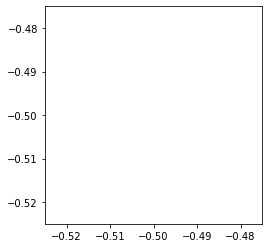

In [102]:
#data
plt.imshow(image[cropped_clip])

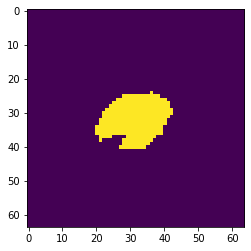

In [343]:
plt.imshow(mask[cropped_clip])

In [347]:
source_image = convert_to_imageio_rich(image[cropped_clip])
inputs, labels = torch.tensor(source_image[np.newaxis, np.newaxis,:,:]).to(device), torch.tensor(mask[cropped_clip][np.newaxis, np.newaxis,:,:]).to(device)
mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
outputs = np.squeeze(mask_pre_prob).detach().cpu()
mask_pre = np.where(outputs>0.5, 1,0)
mask_pre = torch.from_numpy(mask_pre)
score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre[np.newaxis,:,:])
print("Score = {}".format(score))

Lossy conversion from float32 to uint8. Range [-0.17634423077106476, 2.1623523235321045]. Convert image to uint8 prior to saving to suppress this warning.


Score = 0.8969465494155884


In [358]:
print(len(np.unique(source_image)))

239


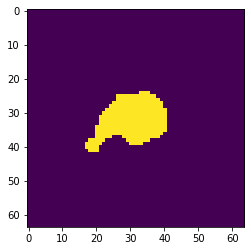

In [348]:
plt.imshow(mask_pre)

In [226]:
labels.shape

torch.Size([1, 1, 64, 64])

In [233]:
ls /data/unet/val/images/

img_LIDC-IDRI-0010_0_207.jpg         img_out_LIDC-IDRI-0526_0_8_52.jpg
img_LIDC-IDRI-0010_0_208.jpg         img_out_LIDC-IDRI-0526_0_9_52.jpg
img_LIDC-IDRI-0010_0_209.jpg         img_out_LIDC-IDRI-0526_1_0_55.jpg
img_LIDC-IDRI-0010_0_210.jpg         img_out_LIDC-IDRI-0526_1_1_55.jpg
img_LIDC-IDRI-0010_0_211.jpg         img_out_LIDC-IDRI-0526_1_2_56.jpg
img_LIDC-IDRI-0010_0_212.jpg         img_out_LIDC-IDRI-0526_1_3_56.jpg
img_LIDC-IDRI-0011_0_27.jpg          img_out_LIDC-IDRI-0526_1_4_57.jpg
img_LIDC-IDRI-0011_0_28.jpg          img_out_LIDC-IDRI-0526_1_5_57.jpg
img_LIDC-IDRI-0011_0_29.jpg          img_out_LIDC-IDRI-0526_1_6_58.jpg
img_LIDC-IDRI-0011_0_30.jpg          img_out_LIDC-IDRI-0526_1_7_58.jpg
img_LIDC-IDRI-0011_0_31.jpg          img_out_LIDC-IDRI-0526_2_0_79.jpg
img_LIDC-IDRI-0011_1_58.jpg          img_out_LIDC-IDRI-0526_2_10_84.jpg
img_LIDC-IDRI-0011_1_59.jpg          img_out_LIDC-IDRI-0526_2_11_84.jpg
img_LIDC-IDRI-0011_2_102.jpg         img_out_LIDC-IDRI-0526_2_12_85.jpg
img

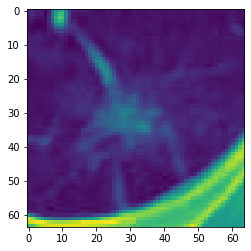

In [360]:
image = Image.open('/data/unet/train/images/img_LIDC-IDRI-0001_0_86.jpg')
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)
plt.imshow(image)

In [361]:
len(np.unique(image))

241

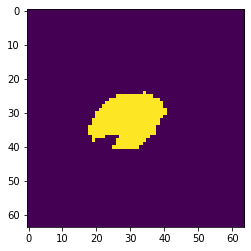

In [359]:
mask = Image.open('/data/unet/train/masks/mask_LIDC-IDRI-0001_0_86.jpg')
mask = mask.convert('1')
mask = np.array(mask)
mask = mask.astype(np.uint8)
plt.imshow(mask)

In [354]:
inputs, labels = torch.tensor(image[np.newaxis, np.newaxis,:,:]).to(device), torch.tensor(mask[np.newaxis, np.newaxis,:,:]).to(device)
mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
outputs = np.squeeze(mask_pre_prob).detach().cpu()
mask_pre = np.where(outputs>0.5, 1,0)
mask_pre = torch.from_numpy(mask_pre)
score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre[np.newaxis,:,:])
print("Score = {}".format(score))

Score = 0.9070631861686707


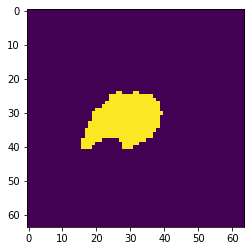

In [355]:
plt.imshow(mask_pre)

In [329]:
fullsize_mask_folder = '/data/unet/fullsize/train/images/'
image = Image.open(fullsize_mask_folder + imgname)
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)
print(image.shape)
len(np.unique(image))

(512, 512)


247

In [267]:
image = Image.open('/data/unet/train/images/img_LIDC-IDRI-0001_0_86.jpg')
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)
print(image.shape)
len(np.unique(image))

(64, 64)


241

Lossy conversion from float32 to uint8. Range [-0.17634423077106476, 2.1623523235321045]. Convert image to uint8 prior to saving to suppress this warning.


(64, 64)
89
(64, 64)


239

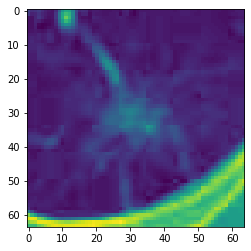

In [330]:
clip, files = get_predicted_box('exp20')
clip = yolo_bbox_to_slice(clip)
cropped_clip = get_nodule_part(clip, random=False)
plt.imshow(image[cropped_clip])
print(image[cropped_clip].shape)
len(np.unique(image[cropped_clip]))
temp_file = '/data/sample/temp/temp.jpg'
print(len(np.unique(image[cropped_clip])))
imageio.imwrite(temp_file, image[cropped_clip])
im = Image.open(temp_file)
im = np.array(im).astype('float32')
im -= np.mean(im)
im /= np.std(im)
print(im.shape)
len(np.unique(im))

In [315]:
!mkdir -p /data/sample/temp

In [316]:
ls /data/sample/temp

### https://stackoverflow.com/questions/19124591/why-imageio-write-method-modifies-pixel-values

We are using images generated using imageio for the unet / segmentation model training, the cropped images also have a rich set of values, upto ~240 unique values. However, when cropping an image read from PIL image open, the range of the values in the cropped image is quite small.
Therefore, we need to use imageio to convert the values in the cropped image to a rich set of values.

In [340]:
arr = image[cropped_clip]
from io import BytesIO
import imageio
buf = BytesIO()
imageio.imwrite(buf, arr, format='jpg')
buf.seek(0)
new_arr = Image.open(buf)
new_arr = np.array(new_arr).astype('float32')
new_arr -= np.mean(new_arr)
new_arr /= np.std(new_arr)
len(np.unique(new_arr))

Lossy conversion from float32 to uint8. Range [-0.17634423077106476, 2.1623523235321045]. Convert image to uint8 prior to saving to suppress this warning.


239

In [71]:
from io import BytesIO
import imageio
def convert_to_imageio_rich(cropped_img_array):
    buf = BytesIO()
    imageio.imwrite(buf, cropped_img_array, format='jpg')
    buf.seek(0)
    new_arr = Image.open(buf)
    new_arr = np.array(new_arr).astype('float32')
    new_arr -= np.mean(new_arr)
    new_arr /= np.std(new_arr)
    return new_arr

In [103]:
#load the source image

# get the cropped image from yolo prediction
fullsize_mask_folder = '/data/unet/fullsize/train/images/'
image = Image.open(fullsize_mask_folder + imgname)
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)
#mask = mask.astype(np.uint8)
#note, y and x are flipped
clip = yolo_bbox_to_slice(convert_yolo_to_bounding_box((x, y, w, h)))
#plt.imshow(img[clip])
cropped_clip = get_nodule_part(clip, random=False)
#plt.imshow(image[cropped_clip])

# true mask

#x = 305, y = 358, w = 24, h= 16
#convert the rect coords to slice
fullsize_mask_folder = '/data/unet/fullsize/train/masks/'
mask = Image.open(fullsize_mask_folder + imgname.replace('img','mask'))
mask = mask.convert('1')
mask = np.array(mask)
mask = mask.astype(np.uint8)
#note, y and x are flipped
clip, files = get_predicted_box('exp20')
#clip = yolo_bbox_to_slice(convert_yolo_to_bounding_box((x, y, w, h)))
clip = yolo_bbox_to_slice(clip)
#print("clip = ", clip)
#plt.imshow(mask[clip])
cropped_clip = get_nodule_part(clip, random=False)
#plt.imshow(mask[cropped_clip])

source_image = convert_to_imageio_rich(image[cropped_clip])
inputs, labels = torch.tensor(source_image[np.newaxis, np.newaxis,:,:]).to(device), torch.tensor(mask[cropped_clip][np.newaxis, np.newaxis,:,:]).to(device)
mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
outputs = np.squeeze(mask_pre_prob).detach().cpu()
mask_pre = np.where(outputs>0.5, 1,0)
mask_pre = torch.from_numpy(mask_pre)
score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre[np.newaxis,:,:])
print("Score = {}".format(score))

Lossy conversion from float32 to uint8. Range [-0.17634423077106476, 2.1623523235321045]. Convert image to uint8 prior to saving to suppress this warning.


Score = 0.8969465494155884


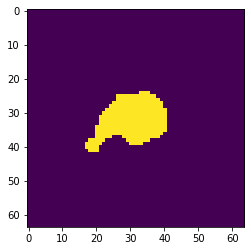

In [104]:
plt.imshow(mask_pre)

In [112]:
#load the source image

# get the cropped image from yolo prediction
imgname = 'img_LIDC-IDRI-0436_0_67.jpg'
fullsize_mask_folder = '/data/unet/test/images/'
image = Image.open(fullsize_mask_folder + imgname)
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)

print("Unique pixels {}".format(len(np.unique(image))))
#mask = mask.astype(np.uint8)
#note, y and x are flipped
clip = yolo_bbox_to_slice(convert_yolo_to_bounding_box((x, y, w, h)))
#plt.imshow(img[clip])
cropped_clip = get_nodule_part(clip, random=False)
#plt.imshow(image[cropped_clip])

# true mask

#x = 305, y = 358, w = 24, h= 16
#convert the rect coords to slice
fullsize_mask_folder = '/data/unet/test/masks/'
mask = Image.open(fullsize_mask_folder + imgname.replace('img','mask'))
mask = mask.convert('1')
mask = np.array(mask)
mask = mask.astype(np.uint8)
# #note, y and x are flipped
# clip, files = get_predicted_box('exp20')
# #clip = yolo_bbox_to_slice(convert_yolo_to_bounding_box((x, y, w, h)))
# clip = yolo_bbox_to_slice(clip)
# #print("clip = ", clip)
# #plt.imshow(mask[clip])
# cropped_clip = get_nodule_part(clip, random=False)
# #plt.imshow(mask[cropped_clip])

#source_image = convert_to_imageio_rich(image)
source_image = image
inputs, labels = torch.tensor(source_image[np.newaxis, np.newaxis,:,:]).to(device), torch.tensor(mask[np.newaxis, np.newaxis,:,:]).to(device)
mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
outputs = np.squeeze(mask_pre_prob).detach().cpu()
mask_pre = np.where(outputs>0.5, 1,0)
mask_pre = torch.from_numpy(mask_pre)
score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre[np.newaxis,:,:])
print("Score = {}".format(score))

Unique pixels 247
Score = 0.8792207837104797


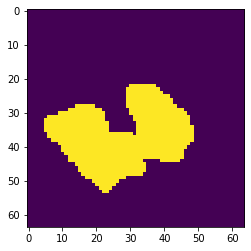

In [110]:
plt.imshow(mask_pre)

In [113]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/data/yolov5/test/sorted_gcsfiles', 'LIDC-IDRI-0436')

Loading dicom files ... This may take a moment.


In [114]:
slices_with_mask

array([57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70.])

Text(0.5, 1.0, 'Predicted')

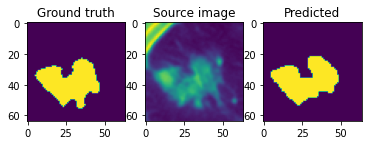

In [148]:
f, a = plt.subplots(1,3)
a[0].imshow(CT_mask[cbbox[0]][:,:,10])
a[0].set_title('Ground truth')

#predict 
image = vol[cbbox[0]][:,:,10]
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)

a[1].imshow(image)
a[1].set_title('Source image')


inputs = torch.tensor(image[np.newaxis, np.newaxis,:,:]).to(device)
mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
outputs = np.squeeze(mask_pre_prob).detach().cpu()
mask_pre = np.where(outputs>0.5, 1,0)
mask_pre = torch.from_numpy(mask_pre)
a[2].imshow(mask_pre)
a[2].set_title('Predicted')

In [145]:
cbbox[0]

(slice(175, 239, None), slice(87, 151, None), slice(57, 70, None))

Text(0.5, 1.0, 'Predicted')

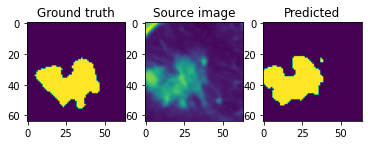

In [150]:
#shift a few pixels down

f, a = plt.subplots(1,3)
a[0].imshow(CT_mask[cbbox[0]][:,:,10])
a[0].set_title('Ground truth')

#predict 
image = vol[(slice(175, 239, None), slice(97, 161, None), slice(57, 70, None))][:,:,10]
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)

a[1].imshow(image)
a[1].set_title('Source image')

inputs = torch.tensor(image[np.newaxis, np.newaxis,:,:]).to(device)
mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
outputs = np.squeeze(mask_pre_prob).detach().cpu()
mask_pre = np.where(outputs>0.5, 1,0)
mask_pre = torch.from_numpy(mask_pre)
a[2].imshow(mask_pre)
a[2].set_title('Predicted')

Text(0.5, 1.0, 'Predicted')

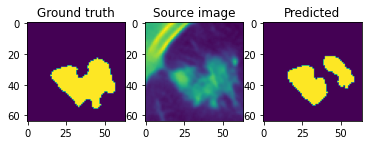

In [156]:
#shift a few pixels up

f, a = plt.subplots(1,3)

new_slice = (slice(175, 239, None), slice(77, 141, None), slice(57, 70, None))


#predict 
image = vol[new_slice][:,:,10]
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)

a[1].imshow(image)
a[1].set_title('Source image')

a[0].imshow(CT_mask[new_slice][:,:,10])
a[0].set_title('Ground truth')

inputs = torch.tensor(image[np.newaxis, np.newaxis,:,:]).to(device)
mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
outputs = np.squeeze(mask_pre_prob).detach().cpu()
mask_pre = np.where(outputs>0.5, 1,0)
mask_pre = torch.from_numpy(mask_pre)
a[2].imshow(mask_pre)
a[2].set_title('Predicted')

Text(0.5, 1.0, 'Predicted')

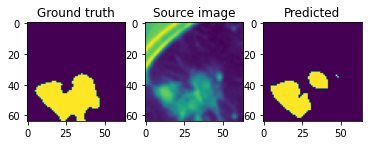

In [155]:
#shift a few pixels up

f, a = plt.subplots(1,3)


#predict 
new_slice = (slice(165, 229, None), slice(87, 151, None), slice(57, 70, None))
image = vol[new_slice][:,:,10]
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)

a[0].imshow(CT_mask[new_slice][:,:,10])
a[0].set_title('Ground truth')


a[1].imshow(image)
a[1].set_title('Source image')

inputs = torch.tensor(image[np.newaxis, np.newaxis,:,:]).to(device)
mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
outputs = np.squeeze(mask_pre_prob).detach().cpu()
mask_pre = np.where(outputs>0.5, 1,0)
mask_pre = torch.from_numpy(mask_pre)
a[2].imshow(mask_pre)
a[2].set_title('Predicted')

#### Try random crop for Yolo model training

In [182]:
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.io import read_image

In [174]:
ls /data/yolov5/train/images/LIDC-IDRI-0001_118.jpg

/data/yolov5/train/images/LIDC-IDRI-0001_118.jpg


In [190]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        print(len(np.unique(np.asarray(img))))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [183]:
transforms = torch.nn.Sequential(
    T.RandomCrop(224),
    T.RandomHorizontalFlip(p=0.3),
)

255


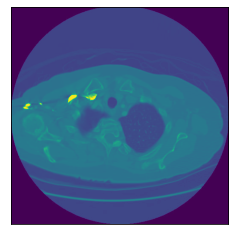

In [191]:
nodule = read_image('/data/yolov5/train/images/LIDC-IDRI-0001_118.jpg')
show(nodule)

204


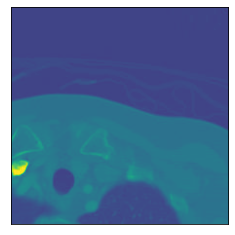

In [195]:
transformed_nodule = transforms(nodule)
show(transformed_nodule)

In [ ]:
Image.open('/data/yolov5/train/images/LIDC-IDRI-0001_118.jpg')

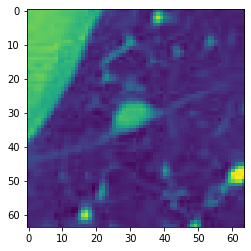

In [31]:
image = Image.open('/data/unet/test/images/img_LIDC-IDRI-0052_0_84.jpg')
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)
plt.imshow(image)

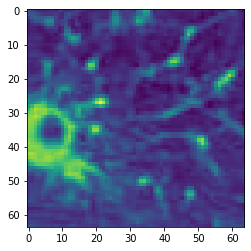

In [32]:
image = Image.open('/data/unet/test/images/img_LIDC-IDRI-0052_1_228.jpg')
image = np.array(image).astype('float32')
image -= np.mean(image)
image /= np.std(image)
plt.imshow(image)

In [40]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/data/yolov5/test/sorted_gcsfiles', 'LIDC-IDRI-0052')

Loading dicom files ... This may take a moment.


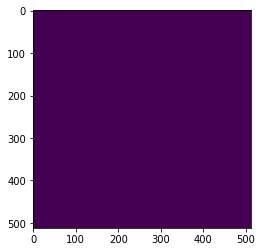

In [45]:
plt.imshow(CT_mask[:,:,67])

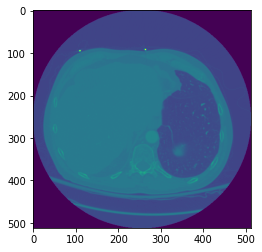

In [43]:
plt.imshow(vol[:,:,67])

In [44]:
slices_with_mask

array([ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88., 221., 222.,
       223., 224., 225., 226., 227., 228., 229., 230., 231., 232., 233.,
       234., 235., 236., 237., 238., 239., 240., 241., 242., 243., 244.,
       245., 246., 247., 248., 249., 250., 251., 252.])

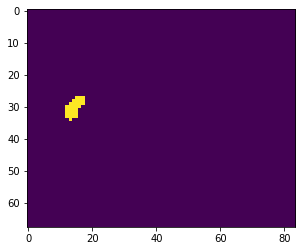

In [69]:
plt.imshow(CT_mask[cbbox[1]][:,:,0])

In [67]:
cbbox

[(slice(226, 240, None), slice(341, 359, None), slice(80, 88, None)),
 (slice(273, 341, None), slice(140, 224, None), slice(221, 252, None))]